<a href="https://colab.research.google.com/github/SeongcheolKim/SFFO/blob/master/cifar_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
#데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [5]:
#이미지 크기 변경 및 정규화(32, 32)->(224, 224)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 레이블 원-핫 인코딩
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

#Train 데이터에서 20%를 Validation으로 사용
validation_split = 0.2
num_train_samples = int(len(x_train) * (1 - validation_split))  # 80% Train, 20% Validation

# Train / Validation 분할
x_train_new, x_val = x_train[:num_train_samples], x_train[num_train_samples:]
y_train_new, y_val = y_train[:num_train_samples], y_train[num_train_samples:]

#배치 크기 설정
batch_size = 32

#데이터셋을 만들고 즉시 리사이징하지 않음 (메모리 절약)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#배치 단위로 변환 (메모리 사용 최적화)
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 실시간 리사이징 (RAM 사용 감소)
    return image, label

#데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_new, y_train_new))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#데이터셋 최적화 (map, batch, prefetch 사용)
train_dataset = (train_dataset
                 .shuffle(len(x_train_new))  # 데이터 섞기
                 .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))  # I/O 최적화

val_dataset = (val_dataset
               .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE))

test_dataset = (test_dataset
                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
#fine-tuning 용 FC 추가
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation = 'softmax')
])

In [12]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-04),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "model_feature.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = callbacks
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 329s 245ms/step - accuracy: 0.2936 - loss: 1.9200 - val_accuracy: 0.1013 - val_loss: 15.5023
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 321s 247ms/step - accuracy: 0.3874 - loss: 1.6996 - val_accuracy: 0.1355 - val_loss: 10.3912
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 314s 251ms/step - accuracy: 0.4104 - loss: 1.6435 - val_accuracy: 0.2041 - val_loss: 7.3744
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 251ms/step - accuracy: 0.4278 - loss: 1.6093 - val_accuracy: 0.1607 - val_loss: 4.0214
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 325s 254ms/step - accuracy: 0.4340 - loss: 1.5811 - val_accuracy: 0.3041 - val_loss: 2.5456
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 313s 246ms/step - accuracy: 0.4431 - loss: 1.5517 - val_accuracy: 0.1530 - val_loss: 3.4745
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 247ms/step - accuracy: 0.4513 - loss: 1.5411 - val_accuracy: 0.1575 - val_loss: 4.5944
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 247ms/step - 

In [14]:
# ResNet50의 마지막 몇 개의 레이어를 학습 가능하게 변경
for layer in base_model.layers[-50:]:
    if not isinstance(layer, layers.BatchNormalization):  # BatchNorm Freeze
        layer.trainable = True


# 모델 재컴파일
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

#scheduler 추가
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "model_feature_finetune.keras",
        save_best_only = True,
        monitor = "val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(  #Validation Loss가 개선되지 않으면 LR 감소
        monitor="val_loss",
        factor=0.5,  # 학습률 50% 감소
        patience=3,  # 3번 연속 개선되지 않으면 감소
        min_lr=1e-6  # 최소 학습률 제한
    )
]

# Fine-Tuning 학습
history_finetune = model.fit(
    train_dataset,
    epochs=15,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 325s 246ms/step - accuracy: 0.4982 - loss: 1.4150 - val_accuracy: 0.5153 - val_loss: 1.3366 - learning_rate: 1.0000e-05
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 329s 252ms/step - accuracy: 0.5188 - loss: 1.3714 - val_accuracy: 0.5313 - val_loss: 1.2932 - learning_rate: 1.0000e-05
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 252ms/step - accuracy: 0.5232 - loss: 1.3666 - val_accuracy: 0.5407 - val_loss: 1.2753 - learning_rate: 1.0000e-05
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 307s 246ms/step - accuracy: 0.5219 - loss: 1.3485 - val_accuracy: 0.5369 - val_loss: 1.3028 - learning_rate: 1.0000e-05
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 245ms/step - accuracy: 0.5239 - loss: 1.3382 - val_accuracy: 0.5136 - val_loss: 1.4344 - learning_rate: 1.0000e-05
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 323s 246ms/step - accuracy: 0.5276 - loss: 1.3330 - val_accuracy: 0.5014 - val_loss: 1.3735 - learning_rate: 1.0000e-05
Epoch 7/15
1250/1250 ━━━━━━━

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.5889 - loss: 1.1576
Test Accuracy: 0.5823


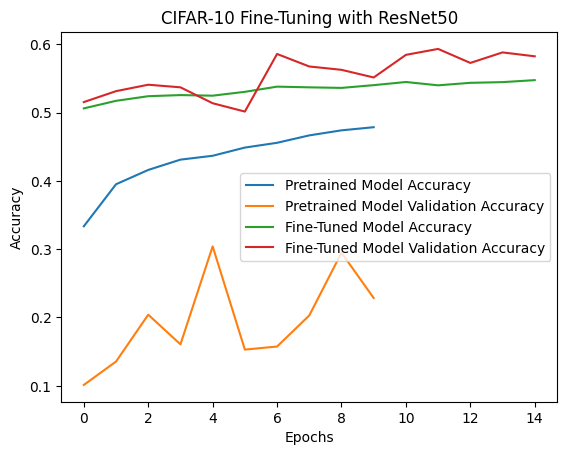

In [16]:
# 학습 및 검증 정확도 그래프
plt.plot(history.history["accuracy"], label="Pretrained Model Accuracy")
plt.plot(history.history["val_accuracy"], label="Pretrained Model Validation Accuracy")
plt.plot(history_finetune.history["accuracy"], label="Fine-Tuned Model Accuracy")
plt.plot(history_finetune.history["val_accuracy"], label="Fine-Tuned Model Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CIFAR-10 Fine-Tuning with ResNet50")
plt.show()